# 43、深度学习（下）：如何使用Keras搭建深度学习网络做手写数字识别

通过之前的深度学习知识的学习，我们已经对神经网络和深度学习有了基本的了解。我们可以使用Keras这个深度学习框架做一个识别手写数字的练习

我们还记得，在KNN算法中我们使用过MNIST手写数字识别这个数据集，当时使用的是mini版本的手写数字数据集。实际上完整的Mnist一共有60000个训练样本和10000个测试样本，这么庞大的数据量更加适合使用深度学习框架完成训练。

我们的学习目标是包括下面几个方面：
- 1、进一步了解CNN网络。CNN网络在深度学习网络中应用很广，很多网络都是基于CNN网络构建的，你有必要进一步了解CNN的网络层次，尤其是关于卷积的原理。
- 2、初步了解LeNet和AlexNet。他们都是经典的CNN网络，我们今天的任务是认识这些经典的CNN网络，这样在接触到更深度的CNN网络的时候，比如VGG、GoogleNet和ResNet这些网络的时候，就会更加容易理解和使用
- 3、对常用的深度学习框架进行对比，包括TensorFlow、Keras、Caffe、PyTorch、MXnet和Theano。当选择深度学习框架的时候到底该选择哪个？
- 4、使用Keras这个深度学习框架编写代码，完成第一个深度学习任务，也就是Mnist手写数字的识别。

## 如何理解CNN网络中的卷积作用

CNN的网络结构有三种层组成，他们分别是卷积层、池化层和全连接层。

在之前的学习中，我们知道卷积层相当于滤镜的作用，它可以把图像分块，对每一块的图像进行卷积操作

卷积本身是一种矩阵运算，那什么是卷积呢?

假设我有一个二维的图像X，和卷积K，把二维的矩阵X进行卷积K操作之后，就可以得到矩阵Z，如下图所示：
![](卷积操作.jpg)

我们需要知道计算的原理：

第一步，我们需要将卷积核翻转180度（只有翻转之后才能做矩阵运算），也就是变成：
![](卷积核.jpg)

第二步，将卷积核的第一个元素，对准矩阵X左上角的第一个元素，对应的元素相乘，然后再相加可以得到`10*1+10*1+10*0+10*1+5*0+5*-1+10*0+5*-1+5*-1=15`
![](待卷积变换矩阵.jpg)

第三步，每个元素都重复第二步的计算过程，可以得到如下的矩阵结果Z：
![](卷积变换结果矩阵.jpg)

这样我们就完成了一个卷积的操作。如果编写代码的话，可以这样写：

In [1]:
import pylab
import numpy as np
from scipy import signal
#设置原来图像
img = np.array([[10,10,10,10,10],
                [10,5,5,5,10],
                [10,5,5,5,10],
                [10,5,5,5,10],
                [10,10,10,10,10]])
# 设置卷积核
fil = np.array([[-1, -1,0],
                [-1, 0, 1],
                [0,  1, 1]])
# 对原图像进行卷积操作
res = signal.convolve2d(img, fil, mode='valid')
# 输出卷积之后的结果
print(res)


[[ 15  10   0]
 [ 10   0 -10]
 [  0 -10 -15]]


这里使用了convolve2d函数对图像img和卷积核fil做卷积运算，最后输出结果res。

疑问：为什么我们要对图像进行卷积操作呢？ 可以看一下下面的一段代码：

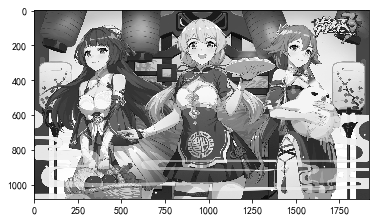

[[  22    0    0 ...    0    0    0]
 [  23    0    0 ...    1    1    0]
 [  24    0    0 ...    2    1   -2]
 ...
 [-172 -332 -166 ...    0    0    0]
 [-172 -332 -166 ...    1    2    1]
 [-172 -332 -166 ...    2    3    0]]


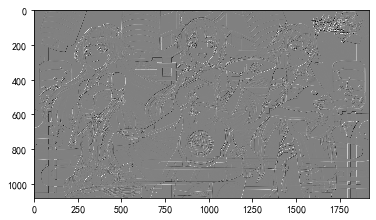

In [2]:
import matplotlib.pyplot as plt
import pylab
import cv2
import numpy as np
from scipy import signal
# 设置灰度图像
img = cv2.imread("haibao.jpg", 0)
# 显示灰度图像
plt.imshow(img,cmap="gray")
pylab.show()
# 设置卷积核
fil = np.array([[-1, -1,0],
                [-1, 0, 1],
                [0,  1, 1]])
# 卷积操作
res = signal.convolve2d(img, fil, mode='valid')
print(res)
# 显示卷积之后的照片
plt.imshow(res,cmap="gray")
pylab.show()


这里先安装`sudo pip3 install opencv-python`,才能引入cv2.对海报做了卷积的操作，我们能够看到卷积操作是对图像进行了特征提取。实际上每一个卷积核都是一种过滤器，他们把图像中符合条件的部分筛选出来，也就相当于做了某种特征提取。

在CNN的卷积层中可以有多个卷积核，以LeNet为例，它的第一层卷积核有6个，因此可以帮助我们提取出图像的6个特征，从而得到6个特征图（feature maps）。

In [10]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


## 激活函数的作用

做完卷积操作之后，通常还需要使用激活函数对图像法进行处理。在逻辑回归中，我们学习了Sigmoid函数，它在深度学习中有广泛的应用，除了Sigmoid函数作为激活函数以外，tanh、ReLU都是常用的激活函数。

这些激活函数通常都是非线性的函数，使用他们的目的的把线性数值映射到非线性的空间中。卷积操作实际上是两个矩阵之间的乘法，得到的结果也是线性的，只有通过非线性的激活函数运算之后，才能映射到非线性空间中，这样也可以让神经网络的表达能力更加强大。

## 池化层的作用

池化层通常在两个卷积层之间，它的作用相当于对神经元的数据做降维处理，这样就能够降低整体的计算量。

假设池化层的窗口大小是2 * 2，就相当于用一个2 * 2 的窗口对输出数据进行处理，将会原图中的2 * 2矩阵的4个点变成一个点。常用的池化层操作是平均池化层和最大池化层。平均池化是对特征点求平均值，也就是用4个点的平均值来做代表。最大池化层则是对特征点求最大值，也就是4个点的最大值来做代表。

在神经网络中，我们可以叠加多个卷积层和池化层来提取更加抽象的特征。经过几次卷积和池化之后，通常会有一个或者多个全连接层。

## 全连接层的作用

全连接层将前面一层的输出结果与当前层的每个神经元都进行了连接。

这样就可以把前面的计算出来的所有特征，通过全连接层将输出值输送到分类器，比如Softmax分类器。在深度学习中，softmax是个很有用的分类器，通过它可以把输入的值映射到0-1之间，而且所有输出的结果相加等于1。其实我们可以换种方式理解这个概念，假设我们想要识别一个数字，从0到9都有可能。那么通过Softmax层，对输出的10中分类结果，每一种结果都有一个概率，这些概率相加为1，我们就可以知道这个数字是0的概率是多少，是1的概率是多少...是9的概率又是多少，从而也就帮我们完成了数字的识别的任务。

其实就是通过一个概率来识别，类似于人的识别。

## LeNet和AlexNet网络

我们能看出CNN网络结构中每一层的作用：它通过卷积层提取特征，通过激活函数让结果映射到非线性空间，增强了结果的表达能力，再通过池化层压缩特征图，降低了网络复杂度，最后通过全连接层归一化，然后连接Softmax分类器进行计算每个类别的概率。

通常我们可以使用多个卷积层和池化层，最后再连接一个或者多个全连接层，这样也就产生了不同的网络结构，比如LeNet和AlexNet。

将LeNet和ALexNet的参数特征整理如下：

|网络结构|输入尺寸|卷积层|池化层|全连接层|输出类别层|
|--|--|--|--|--|--|
|LetNet|32*32|3|2|2|10|
|AlexNet|227*227*3|5|3|3|1000|

LeNet提出于1986年，是最早的用于数字识别的CNN网络，输入的尺寸是32*32。它输入的是灰度的图像，整个的网络结构是：输入层->C1卷积层->S2池化层->C3卷积层->S4池化层->C5卷积层->F6全连接层，对应的Output输出类别数为10.

AlexNet在LeNet的基础上做了改进提出了更深的CNN网络，输入尺寸是227 * 227 * 3 ，可以输入RGB三通道的图像，整个的网络结构是：输入层->(C1卷积层->池化层)->(C2卷积层->池化层)->C3卷积层->C4卷积层->(C5池化层->池化层)->全连接层->全连接层->Output全连接层。

实际上后面提出来的深度模型，比如VGG、GoogleNet和ResNet都是基于下面的这种结构方式改进的：输出层->(卷积层 + ->池化层？) + ->全连接层+ ->Output全连接层。

其中“+”代表1个或者多个，“？”代表0个或者1个。

我们能够看出卷积层后面可以有一个池化层，也可以没有池化层，“卷积层 + —>池化层？”这样的结构算是一组卷积层，在多组卷积层之后，可以连接多个全连接层，最后再接Output全连接层。

## 常用的深度学习框架对比

了解CNN的网络结构之后，我们来看下常用的深度学习框架都有哪些；

下面这张图是常用的框架的简单对比。

|框架|主要语言|GitHub Stars|
|--|--|--|
|Tensorflow|Python/C++/Go|123K|
|Keras|Python|39K|
|Caffe|C++/Python|27.4K|
|PyTorch|Python|25.9K|
|MxNet|Pyhton/C++/R|16.5K|
|Theano|Python|8.7k|

从GitHub上的热门程序来看，TensorFlow、Keras和Caffe是三个排名最高的深度学习框架，其中TensorFlow是Google出品，也是深度学习最常用的库。关于Keras，我们可以理解为是把TensorFlow或者是Theano作为后端，基于它们提供的封装接口，这样方便我们进行操作使用。Caffe、PyTorch、MXNet和Theano也是常用的深度学习库，只要学习深度学习就会遇到。

这里我们刚刚进入深度学习这个领域，建议直接使用Keras，因为它使用方便，更加友好，可以方便我们快速构建网络模型，不需要过多关注底层细节。

## 用Keras做Mnist手写数字识别

Keras是基于Python语言的。在使用Keras之前，我们需要安装相应的工具包：

In [ ]:
sudo pip3 install keras
sudo pip3 install tensorflow

这里需要注明的是Keras需要使用TensorFlow或者theano作为后端，因此我们也需要引入相关的工具。同时我们还需要注意Numpy的版本是否是最新的版本，我们需要采用最新的Numpy版本才能正常运行Keras，更新Numpy工具的方法是：

In [ ]:
sudo pip3 install -U Numpy

安装好Keras工具之后，就可以创建一个Sequential序贯模型，它的作用是将多个网络层线性堆叠起来，使用的方法是：

In [ ]:
from keras.models import Sequential
model = Sequential()

然后就可以在网络层中添加各种层了

### 创建二维卷积层

使用Conv2D(filters,kernel_size,activation=None)进行创建，其中filters代表的是卷积核的数量，kernel_size代表的是卷积核的宽度和长度，activation代表的是激活函数。如果创建的是二维的卷积层是第一个卷积层，我们还需要提供input_shape参数，比如：input_shape=(28,28,1)代表的就是28*28的灰度图像。


### 对2D信号做最大池化层

使用MaxPooling2D(pool_size=(2,2))进行创建，其中pool_size代表下采样的因子，比如pool_size=(2,2)的时候相当于将原来的22的矩阵变成一个点，就是用22矩阵中的最大值代替，输出的图像在长度和宽度上均为原图的一半。

### 创建Flatten层

使用Flatten()创建，常用于将多维度的输入扁平化，也就是展开为一维空间的向量。一般在卷积层与全连接层之间，方便后面进行全连接层的操作

### 创建全连接层

使用Dense(units,activation=None)进行创建，其中units代表的是输出的空间维度,activation代表的是激活函数。

这里只列举了部分常用的层，这些层在今天的手写数字识别的项目中会使用到。当我们把层创建好之后，可以加入到模型中，使用model.add()函数即可。

添加好网络模型中的层之后，我们可以使用model.compile(loss,optimizer='adam',metrics=['accuracy'])来完成损失函数和优化器的配置，其中loss代表损失函数的配置，optimizer代表的是优化器，metrics代表的是评估模型所采用的指标。

然后我们就可以使用fit函数进行训练，使用predict函数进行预测，使用evaluate函数对模型评估。

针对Mnist手写数字识别，使用keras的实现代码如下:

In [3]:
# 使用LeNet模型对Mnist手写数字进行识别
import keras
from keras.datasets import mnist
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Dense,Flatten
from keras.models import Sequential
# 数据加载
(train_x, train_y), (test_x, test_y) = mnist.load_data()
# 输入数据为mnist数据集
train_x = train_x.reshape(train_x.shape[0],28,28,1)
test_x = test_x.reshape(test_x.shape[0],28,28,1)
train_x = train_x / 255
test_x = test_x / 255
train_y = keras.utils.to_categorical(train_y,10)
test_y = keras.utils.to_categorical(test_y,10)
# 创建序贯模型
model = Sequential()
# 第一层卷积层：6个卷积核，大小为5*5，relu激活函数
model.add(Conv2D(6,kernel_size=(5,5), activation='relu',input_shape=(28,28,1)))
# 第二层池化层：最大池化
model.add(MaxPooling2D(pool_size=(2,2)))
# 第三层卷积层:16个卷积层，大小为5*5，relu是激活函数
model.add(Conv2D(16,kernel_size=(5,5), activation='relu'))
# 第二层池化层：最大池化
model.add(MaxPooling2D(pool_size=(2,2)))
# 将参数进行扁平化，在LeNet5中的称作卷积层，实际上这一层是一维向量，和全连接层一样
model.add(Flatten())
model.add(Dense(120, activation = 'relu'))
# 全连接层，输出结点个数为84个
model.add(Dense(84, activation='relu'))
# 输出层用softmax 激活函数计算分类概率
model.add(Dense(10, activation='softmax'))
# 设置损失函数和优化器配置
model.compile(loss=keras.metrics.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
# 传入训练数据进行训练（使用epochs控制训练的次数）
model.fit(train_x, train_y, batch_size=128,epochs=2,verbose=1,validation_data=(test_x,test_y))
# 对结果进行评估
score = model.evaluate(test_x, test_y)
print('误差：%0.4lf' %score[0])
print('准确率：', score[1])
 

W0808 17:01:11.291724 139996808750912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 17:01:11.324042 139996808750912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 17:01:11.332075 139996808750912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 17:01:11.388644 139996808750912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0808 17:01:11.682385 139996808750912 deprecation_wrapp

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 26s 434us/step - loss: 0.3371 - acc: 0.9000 - val_loss: 0.0972 - val_acc: 0.9711
Epoch 2/2
10000/10000 [==============================] - 3s 258us/step
误差：0.0686
准确率： 0.9796


使用epochs控制了训练的次数2次，当训练的次数为2遍的时候，准确率达到97.96%，还是很高的。

注意：mnis数据集的名称叫mnist.npz,存放的路径是/home/toohoo/.keras/datasets，因为本地刚开始时没有这个数据集的，所会先下载这个数据集，决定于网络环境，如果网络不好，可以先自行下载这个数据集，放到指定的路径下面之后，运行监测出来就不会再下载。

## 总结

1、可以通过查询keras的API进行更多的知识学习

2、在这个过程里面，我们只是使用了LeNet的网络模型，实际上AlexNet，VGG，GoogleNet和ResNet都是基于CNN的网络结构。在CNN网络中包含了卷积层、池化层和全连接层。

3、一个基于CNN的深度学习网络通常是几组卷积层之后，再连接多个全连接层，最后再连接Output全连接层，而每组的卷积层收拾“卷积层+->池化层？”的结构。

4、另外，通过今天的学习我们知道卷积在图像领域中的应用。例如对专栏海报进行了一个3 * 3的卷积核操作，可以看到卷积之后得到的图像是原图像的某种特征的提取。在实际的卷积层中，会包含多个卷积核，对原图像在不同的特征上进行提取。通过多个卷积层的操作，可以在更高的维度上对图像特征进一步提取，这样可以让机器在不同的层次，不同的维度理解图像的特征。

5、另外在Keras使用中，我们能看到与sklearn中的机器学习算法使用不同。我们需要对网络模型中的层进行配置，把创建好的层添加到模型中，然后对模型中使用的损失函数和优化器进行配置,最后就可以对它进行训练和预测了。

6、使用Keras实现手写数字的识别
- CNN网络
    - 卷积操作的原理
        - 第一步，我们需要将卷积核翻转180度
        - 第二步,将卷积核的第一个元素，对准矩阵X左上角的第一个元素，然后对应元素相乘，然后再相加
        - 第三步，每个元素都按照第二步的计算过程，可以得到最终的矩阵结果
    - 练习：对专栏海报进行3 * 3的卷积操作
    - 激活函数：将线性数值映射到非线性空间中，让神经网络的表达能力更加强大
    - 池化层：通常是在两个卷积层之间，它相当于对神经元的数据进行降维处理，这样我们就能通过池化层降维降低整体的计算量。
- LeNet和AlexNet网络
    - LeNet和AlexNet的参数对比
    - LeNet：输入层->C1卷积层->S2池化层->C3卷积层->S4池化层->C5卷积层->F6全连接层->Output全连接层，对应的Output输出类别数为10
    - AlexNet：输入层->(C1卷积层->池化层)->(C2卷积层->池化层)->C3卷积层->C4卷积层-（C5池化层->池化层）->全连接层->全连接层->Output全连接层
    - 通用网络结构：输出层->(卷积层+—>池化层？) +->全连接层+->Output全连接层
- 常用的深度学习框架的对比
    - GitHub上最热的3个框架：TensorFlow，Keras和Caffe
    - Keras：适合初学者，基于TensorFlow或者Theano为后端，在他们的基础上提供的封装接口，更加方便我们使用
- 用Keras做Mnist手写数字的识别
    - 安装工具包
        - keras
        - tensorflow
        - numpy
    - 模型创建
        - 序贯模型：Sequential
        - 二维卷积层：Conv2D(filters,kernel_size,activation=None)
        - 对2D信号做最大池化层，使用MaxPooling2D(pool_size=(2,2))
        - Flatten层，使用Flatten进行创建
        - 全连接层，使用Dense(units,activation=None)进行创建
    - 损失函数和优化器的配置：model.compile(loss,optimizer='adam',matrics=['accuracy'])
    - 模型方法
        - fit函数进行训练
        - predict函数进行预测
        - evaluate函数对模型进行评估
![](keras对手写数字进行识别.png)

### 说说卷积、卷积核、卷积层三者的理解
- 卷积是一种操作，就好像是过滤这个动作
- 卷积核是卷积层的组成部分，是卷积操作的一层滤网，多个卷积核形成一个卷积核
- 卷积层相当于一种过滤层，过滤掉不需要的杂质